In [121]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.viridis):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
       # print('Confusion matrix, without normalization')

    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


In [95]:
# Reading data
%config IPCompleter.greedy=True
import numpy as np
import pandas as pd
import itertools

# Read dataset off Github
hs_2017 = pd.read_csv("https://github.com/jeffweltman/MSDS7331/raw/master/hs_2017.csv",index_col=0)

from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import StratifiedShuffleSplit


x = hs_2017.drop(columns=['nc_district', 'sat_high_level', "sat_avg_score_num"])
y = hs_2017.sat_high_level.values

In [9]:
# OLS
from sklearn.model_selection import train_test_split
from sklearn import linear_model, preprocessing
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, r2_score

todrop=hs_2017.columns[hs_2017.columns.str.lower().str.contains('graduation')]

x = hs_2017.drop(columns = ['nc_district', 'sat_high_level', "sat_avg_score_num"])
x = x.drop(columns = todrop.values)
x_scaled = preprocessing.scale(x)
y=hs_2017['GraduationRate_5yr_All']

X_train, X_test, y_train, y_test = train_test_split(x_scaled, y, test_size=0.4, random_state=0)
lr = linear_model.LinearRegression()
scores = cross_val_score(lr, X_train, y_train, cv=10, scoring='r2')
print("R2: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

#lr.fit(X_train, y_train)
#y_preds = lr.predict(X_test)

#mse = mean_squared_error(y_test, y_preds)
#r2 = r2_score(y_test, y_preds)
#precision = precision_score(y_test, y_preds)
#accuracy = accuracy_score(y_test, y_preds)



R2: -7.50 (+/- 8.48)


Precision: 0.88
Accuracy: 0.86
Recall: 0.71


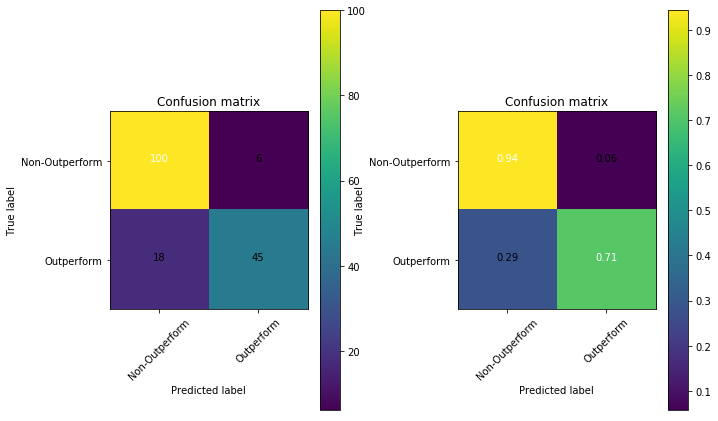

In [122]:
# Random Forrest standard and grid search
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(criterion='entropy', random_state=42)
from sklearn.metrics import precision_score, accuracy_score, confusion_matrix, recall_score

x = hs_2017.drop(columns = ['nc_district', 'sat_high_level', "sat_avg_score_num"])
x = x.drop(columns = todrop.values)
y = hs_2017.sat_high_level.values
X_train, X_test, y_train, y_test = train_test_split(x_scaled, y, test_size=0.4, random_state=0)
rf.fit(X_train, y_train)

print("Precision: %0.2f" % precision_score(y_test, rf.predict(X_test)))
print("Accuracy: %0.2f" % accuracy_score(y_test, rf.predict(X_test)))
print("Recall: %0.2f" % recall_score(y_test, rf.predict(X_test)))

cm = confusion_matrix(y_test, rf.predict(X_test))
plt.figure(figsize = (10, 6))
plt.subplot(1, 2, 1)
plot_confusion_matrix(cm, ['Non-Outperform', 'Outperform'])
plt.subplot(1, 2, 2)
plot_confusion_matrix(cm, ['Non-Outperform', 'Outperform'], normalize=True)

In [115]:
# With grid search

param_grid = {
    'n_estimators': [int(i) for i in range(1,25)],
    'max_depth':    [int(i) for i in range(2,10)],
    'max_features': ['auto', 'sqrt', 'log2'],
    'criterion':    ['gini', 'entropy']
}

# Generate & fit RandomForest with grid search per the above
from sklearn.model_selection import GridSearchCV
rfgc = RandomForestClassifier(random_state=42)
grid_rf = GridSearchCV(rfgc, param_grid, cv=5, scoring="precision")
# The below line of code will take 
#grid_rf.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_estimators': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24], 'max_depth': [2, 3, 4, 5, 6, 7, 8, 9], 'max_features': ['auto', 'sqrt', 'log2'], 'criterion': ['gini', 'entropy']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='precision', verbose=0)

Precision: 0.89
Accuracy: 0.89
Recall: 0.79


 Parameters from best model:
 {'criterion': 'gini', 'max_depth': 6, 'max_features': 'auto', 'n_estimators': 8}


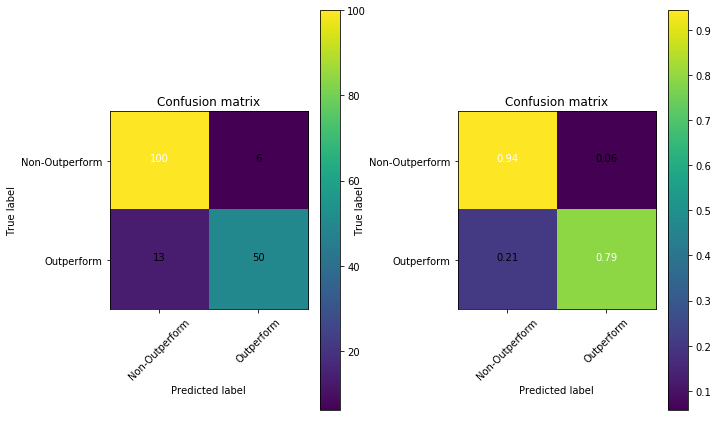

In [124]:
print("Precision: %0.2f" % precision_score(y_test, grid_rf.predict(X_test)))
print("Accuracy: %0.2f" % accuracy_score(y_test, grid_rf.predict(X_test)))
print("Recall: %0.2f" % recall_score(y_test, grid_rf.predict(X_test)))
print("\n\n Parameters from best model:\n", grid_rf.best_params_)


cm = confusion_matrix(y_test, grid_rf.predict(X_test))
plt.figure(figsize = (10, 6))
plt.subplot(1, 2, 1)
plot_confusion_matrix(cm, ['Non-Outperform', 'Outperform'])
plt.subplot(1, 2, 2)
plot_confusion_matrix(cm, ['Non-Outperform', 'Outperform'], normalize=True)




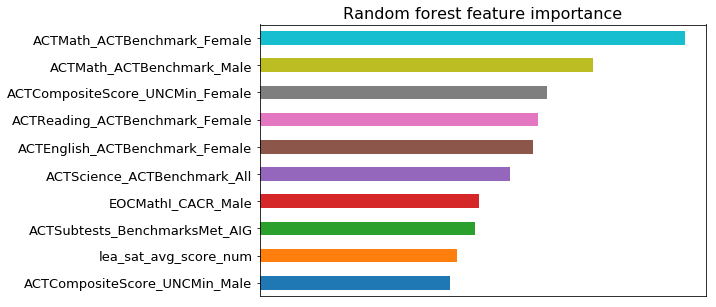

In [83]:
var_imps = pd.DataFrame(x.columns, columns = ['feature'])
var_imps['fscore'] = grid_rf.best_estimator_.feature_importances_[:,]
var_imps['fscore'] = var_imps['fscore'] / var_imps['fscore'].max()
var_imps.sort_values('fscore', ascending = False, inplace = True)
var_imps = var_imps[0:10]
var_imps.sort_values('fscore', ascending = True, inplace = True)
var_imps.plot(kind='barh', x='feature', y='fscore', legend=False, figsize=(8, 5))
plt.title('Random Forest Feature Importance', fontsize = 16)
plt.xlabel('')
plt.ylabel('')
plt.xticks([], [])
plt.yticks(fontsize=13)
plt.show()

In [38]:
grid_rf.best_params_

{'max_depth': 7, 'n_estimators': 10}

[2, 3, 4, 5, 6, 7, 8, 9]